# Deep Learning para Sostenibilidad Pesquera

## FASE D: Modelos Avanzados de Deep Learning

Este notebook implementa y compara diferentes enfoques de Deep Learning para el análisis de sostenibilidad pesquera:

1. **MLP Clásico**: Red neuronal feedforward como baseline
2. **Red Neuronal Bayesiana (BNN)**: Cuantificación de incertidumbre epistémica
3. **Causal VAE**: Generación de contrafactuales

### Ventajas del Deep Learning en este contexto
- Captura relaciones no lineales complejas
- BNN proporciona estimaciones de incertidumbre
- VAE permite análisis contrafactual ("¿qué pasaría si...?")

## 1. Configuración e Importaciones

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from pathlib import Path
import warnings
import sys

# Añadir directorio raíz al path
sys.path.insert(0, str(Path.cwd().parent))

# Importar módulos del proyecto
from data.loaders import generate_synthetic_fisheries_data, prepare_bayesian_dataset
from src.deep_learning.models import (
    SustainabilityMLP, BayesianNeuralNetwork, CausalVAE,
    ModelConfig, create_model
)
from src.deep_learning.training import (
    Trainer, TrainingConfig, TrainingHistory,
    prepare_data_loaders, prepare_sustainability_data,
    train_model, evaluate_model
)

# Configuración
plt.style.use('seaborn-v0_8-whitegrid')
warnings.filterwarnings('ignore')
torch.manual_seed(42)
np.random.seed(42)

# Device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Usando dispositivo: {device}")
print(f"PyTorch version: {torch.__version__}")

Usando dispositivo: cpu
PyTorch version: 2.10.0+cpu


## 2. Preparación de Datos

In [2]:
# Generar datos sintéticos
df = generate_synthetic_fisheries_data(n_samples=1000, random_state=42)

print(f"Dataset shape: {df.shape}")
print(f"\nDistribución de Sostenibilidad:")
print(df['Sustainable'].value_counts())

df.head()

Dataset shape: (1000, 18)

Distribución de Sostenibilidad:
Sustainable
1    874
0    126
Name: count, dtype: int64


,Country,Year,SST_C,Salinity_ppt,Chlorophyll_mg_m3,pH,Fleet_Size,Fishing_Effort_hours,Fuel_Consumption_L,Fish_Price_USD_ton,Fuel_Price_USD_L,Operating_Cost_USD,Capture_Production_Mt,Aquaculture_Production_Mt,Total_Production_Mt,CPUE,Sustainability_Score,Sustainable
0,USA,2013,25.24,38.05,0.791,8.05,31850,47450.0,513571.0,820.21,1.04,573944.0,3.282,4.038,7.321,0.0692,0.607,1
1,Spain,2020,17.38,34.14,0.476,7.96,120,11737.0,358801.0,1478.61,1.04,424182.0,1.694,1.815,3.508,0.1443,0.531,1
2,USA,2011,19.00,34.42,0.548,8.47,2921,7649.0,87008.0,977.77,1.32,139270.0,2.772,3.838,6.610,0.3624,0.696,1
3,Iceland,2019,27.46,36.40,0.842,7.92,17728,48317.0,2340792.0,4138.15,1.34,3204429.0,1.568,2.236,3.804,0.0324,0.529,1
4,South Korea,2018,12.62,32.27,1.889,7.92,6087,81118.0,3816771.0,1527.13,1.27,4902854.0,0.655,1.296,1.952,0.0081,0.463,0


In [3]:
# Preparar datos para Deep Learning
# Excluir columnas no numéricas y de identificación
exclude_cols = ['Country', 'Year', 'Sustainability_Score']

X, y, feature_names = prepare_sustainability_data(
    df, 
    target='Sustainable',
    exclude_cols=exclude_cols
)

print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")
print(f"Features: {feature_names}")
print(f"\nClase positiva: {y.sum()} ({y.mean():.2%})")

X shape: (1000, 14)
y shape: (1000,)
Features: ['SST_C', 'Salinity_ppt', 'Chlorophyll_mg_m3', 'pH', 'Fleet_Size', 'Fishing_Effort_hours', 'Fuel_Consumption_L', 'Fish_Price_USD_ton', 'Fuel_Price_USD_L', 'Operating_Cost_USD', 'Capture_Production_Mt', 'Aquaculture_Production_Mt', 'Total_Production_Mt', 'CPUE']

Clase positiva: 874 (87.40%)


In [4]:
# Crear DataLoaders
train_loader, val_loader, test_loader = prepare_data_loaders(
    X, y,
    batch_size=32,
    val_split=0.15,
    test_split=0.15,
    random_state=42
)

print(f"Train batches: {len(train_loader)}")
print(f"Val batches: {len(val_loader)}")
print(f"Test batches: {len(test_loader)}")

Train batches: 22
Val batches: 5
Test batches: 5


## 3. Modelo 1: MLP Clásico (Baseline)

In [5]:
# Configuración del modelo MLP
input_dim = X.shape[1]
print(f"Input dimension: {input_dim}")

mlp_config = ModelConfig(
    input_dim=input_dim,
    hidden_dims=[64, 32, 16],
    output_dim=1,
    dropout_rate=0.3,
    activation='relu',
    use_batch_norm=True
)

mlp_model = SustainabilityMLP(mlp_config)
print(mlp_model)

Input dimension: 14
SustainabilityMLP(
  (activation): ReLU()
  (feature_extractor): Sequential(
    (0): Linear(in_features=14, out_features=64, bias=True)
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=64, out_features=32, bias=True)
    (5): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.3, inplace=False)
    (8): Linear(in_features=32, out_features=16, bias=True)
    (9): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Dropout(p=0.3, inplace=False)
  )
  (classifier): Linear(in_features=16, out_features=1, bias=True)
)


In [6]:
# Entrenar MLP
training_config = TrainingConfig(
    epochs=100,
    batch_size=32,
    learning_rate=0.001,
    early_stopping_patience=15,
    device=device,
    verbose=True
)

mlp_trainer = Trainer(mlp_model, training_config)
mlp_history = mlp_trainer.fit(train_loader, val_loader)

print(f"\nMejor época: {mlp_history.best_epoch + 1}")
print(f"Mejor val loss: {mlp_history.best_val_loss:.4f}")

Epoch 10/100 - Train Loss: 0.4726 - Val Loss: 0.3467
Epoch 20/100 - Train Loss: 0.2895 - Val Loss: 0.2372
EarlyStopping: 1/15
Epoch 30/100 - Train Loss: 0.2433 - Val Loss: 0.2110
EarlyStopping: 1/15
EarlyStopping: 1/15
Epoch 40/100 - Train Loss: 0.2354 - Val Loss: 0.1927
EarlyStopping: 1/15
EarlyStopping: 2/15
EarlyStopping: 1/15
EarlyStopping: 2/15
EarlyStopping: 3/15
EarlyStopping: 4/15
Epoch 50/100 - Train Loss: 0.2100 - Val Loss: 0.1842
EarlyStopping: 5/15
EarlyStopping: 6/15
EarlyStopping: 7/15
EarlyStopping: 8/15
EarlyStopping: 9/15
EarlyStopping: 10/15
EarlyStopping: 1/15
EarlyStopping: 2/15
Epoch 60/100 - Train Loss: 0.2066 - Val Loss: 0.1820
EarlyStopping: 1/15
EarlyStopping: 2/15
EarlyStopping: 3/15
EarlyStopping: 1/15
EarlyStopping: 2/15
EarlyStopping: 3/15
EarlyStopping: 1/15
Epoch 70/100 - Train Loss: 0.2042 - Val Loss: 0.1843
EarlyStopping: 2/15
EarlyStopping: 3/15
EarlyStopping: 4/15
EarlyStopping: 5/15
EarlyStopping: 6/15
EarlyStopping: 7/15
EarlyStopping: 8/15
EarlySto

In [7]:
# Evaluar MLP en test
X_test = np.vstack([batch[0].numpy() for batch in test_loader])
y_test = np.hstack([batch[1].numpy() for batch in test_loader])

mlp_results = evaluate_model(mlp_model, X_test, y_test, device)

print("=" * 50)
print("RESULTADOS MLP (Test Set)")
print("=" * 50)
for metric, value in mlp_results.items():
    if metric != 'confusion_matrix':
        print(f"{metric:12}: {value:.4f}")

RESULTADOS MLP (Test Set)
accuracy    : 0.9133
precision   : 0.9214
recall      : 0.9847
f1          : 0.9520
auc_roc     : 0.9303


## 4. Modelo 2: Red Neuronal Bayesiana (BNN)

In [8]:
# Crear BNN
bnn_config = ModelConfig(
    input_dim=input_dim,
    hidden_dims=[64, 32],
    output_dim=1
)

bnn_model = BayesianNeuralNetwork(bnn_config, prior_std=1.0)
print("Red Neuronal Bayesiana:")
print(f"  - Capas ocultas: {bnn_config.hidden_dims}")
print(f"  - Prior std: 1.0")

Red Neuronal Bayesiana:
  - Capas ocultas: [64, 32]
  - Prior std: 1.0


In [9]:
# Entrenar BNN
bnn_training_config = TrainingConfig(
    epochs=150,
    batch_size=32,
    learning_rate=0.001,
    early_stopping_patience=20,
    device=device,
    verbose=True
)

bnn_trainer = Trainer(bnn_model, bnn_training_config)
bnn_history = bnn_trainer.fit(train_loader, val_loader)

print(f"\nMejor época: {bnn_history.best_epoch + 1}")

EarlyStopping: 1/20
Epoch 10/150 - Train Loss: 0.3250 - Val Loss: 0.7181
EarlyStopping: 1/20
EarlyStopping: 1/20
EarlyStopping: 2/20
EarlyStopping: 3/20
EarlyStopping: 4/20
EarlyStopping: 1/20
Epoch 20/150 - Train Loss: 0.2821 - Val Loss: 0.6899
EarlyStopping: 1/20
EarlyStopping: 2/20
EarlyStopping: 3/20
EarlyStopping: 1/20
EarlyStopping: 2/20
EarlyStopping: 3/20
Epoch 30/150 - Train Loss: 0.2552 - Val Loss: 0.6656
EarlyStopping: 1/20
EarlyStopping: 2/20
EarlyStopping: 3/20
EarlyStopping: 4/20
EarlyStopping: 5/20
EarlyStopping: 6/20
EarlyStopping: 7/20
Epoch 40/150 - Train Loss: 0.2304 - Val Loss: 0.6453
EarlyStopping: 1/20
EarlyStopping: 2/20
EarlyStopping: 3/20
EarlyStopping: 4/20
EarlyStopping: 5/20
EarlyStopping: 6/20
EarlyStopping: 1/20
EarlyStopping: 2/20
Epoch 50/150 - Train Loss: 0.2192 - Val Loss: 0.6441
EarlyStopping: 3/20
EarlyStopping: 4/20
EarlyStopping: 5/20
EarlyStopping: 6/20
EarlyStopping: 7/20
EarlyStopping: 8/20
EarlyStopping: 9/20
EarlyStopping: 10/20
EarlyStopping:

In [10]:
# Evaluar BNN con cuantificación de incertidumbre
bnn_model.eval()
X_test_tensor = torch.FloatTensor(X_test).to(device)

# Predicción con incertidumbre
mean_prob, std_prob, samples = bnn_model.predict_with_uncertainty(
    X_test_tensor, n_samples=100
)

mean_prob = mean_prob.cpu().numpy().squeeze()
std_prob = std_prob.cpu().numpy().squeeze()

print("=" * 50)
print("RESULTADOS BNN (Test Set)")
print("=" * 50)

bnn_preds = (mean_prob >= 0.5).astype(int)
bnn_accuracy = (bnn_preds == y_test).mean()

print(f"Accuracy: {bnn_accuracy:.4f}")
print(f"\nIncertidumbre epistémica:")
print(f"  - Media: {std_prob.mean():.4f}")
print(f"  - Max: {std_prob.max():.4f}")
print(f"  - Min: {std_prob.min():.4f}")

RESULTADOS BNN (Test Set)
Accuracy: 0.9067

Incertidumbre epistémica:
  - Media: 0.0184
  - Max: 0.1574
  - Min: 0.0000


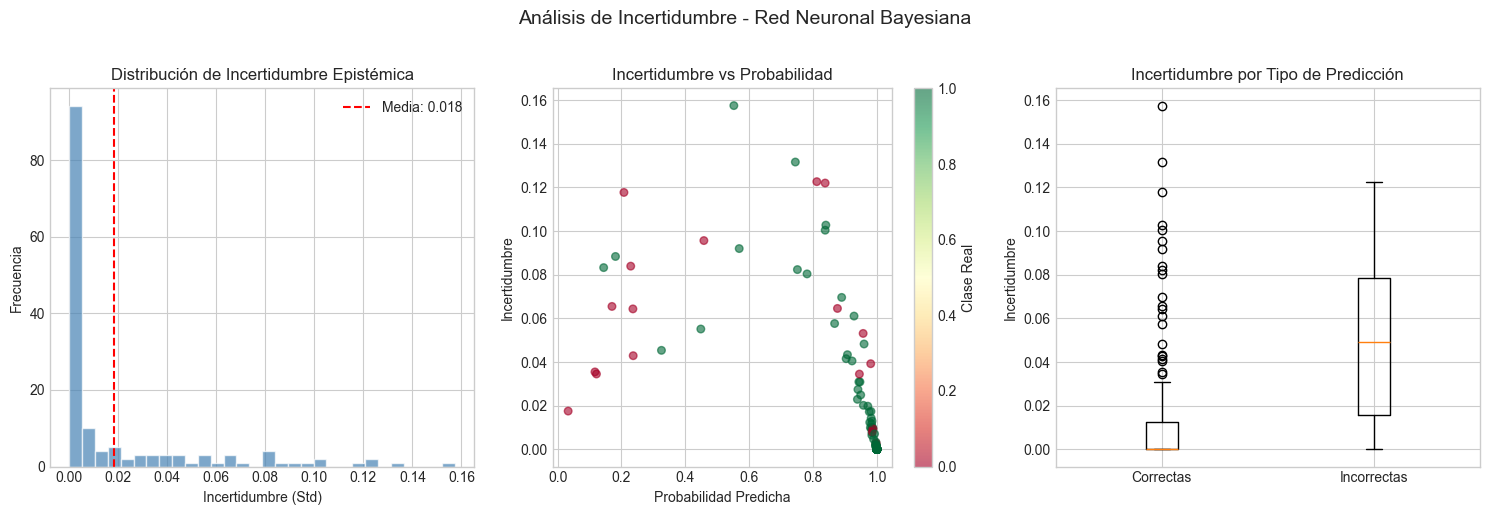


Incertidumbre promedio en predicciones correctas: 0.0150
Incertidumbre promedio en predicciones incorrectas: 0.0520


In [11]:
# Visualizar incertidumbre
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# 1. Distribución de incertidumbre
axes[0].hist(std_prob, bins=30, color='steelblue', edgecolor='white', alpha=0.7)
axes[0].axvline(std_prob.mean(), color='red', linestyle='--', label=f'Media: {std_prob.mean():.3f}')
axes[0].set_xlabel('Incertidumbre (Std)')
axes[0].set_ylabel('Frecuencia')
axes[0].set_title('Distribución de Incertidumbre Epistémica')
axes[0].legend()

# 2. Incertidumbre vs Probabilidad predicha
scatter = axes[1].scatter(mean_prob, std_prob, c=y_test, cmap='RdYlGn', alpha=0.6, s=30)
axes[1].set_xlabel('Probabilidad Predicha')
axes[1].set_ylabel('Incertidumbre')
axes[1].set_title('Incertidumbre vs Probabilidad')
plt.colorbar(scatter, ax=axes[1], label='Clase Real')

# 3. Incertidumbre por predicción correcta/incorrecta
correct = bnn_preds == y_test
axes[2].boxplot([std_prob[correct], std_prob[~correct]], 
                labels=['Correctas', 'Incorrectas'])
axes[2].set_ylabel('Incertidumbre')
axes[2].set_title('Incertidumbre por Tipo de Predicción')

plt.suptitle('Análisis de Incertidumbre - Red Neuronal Bayesiana', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

print(f"\nIncertidumbre promedio en predicciones correctas: {std_prob[correct].mean():.4f}")
print(f"Incertidumbre promedio en predicciones incorrectas: {std_prob[~correct].mean():.4f}")

## 5. Modelo 3: Causal VAE

In [12]:
# Crear Causal VAE
# Definir estructura causal simplificada
# Índices: 0=SST, 1=Salinity, 2=Chlorophyll, etc.
causal_graph = [
    (0, 4),  # SST -> Fishing_Effort
    (2, 5),  # Chlorophyll -> CPUE (asumiendo)
    (4, 6),  # Fishing_Effort -> Fuel_Consumption
]

causal_vae = CausalVAE(
    input_dim=input_dim,
    latent_dim=8,
    hidden_dims=[64, 32],
    causal_graph=causal_graph
).to(device)

print("Causal VAE:")
print(f"  - Input dim: {input_dim}")
print(f"  - Latent dim: 8")
print(f"  - Causal edges: {len(causal_graph)}")

Causal VAE:
  - Input dim: 14
  - Latent dim: 8
  - Causal edges: 3


In [13]:
# Entrenar Causal VAE
vae_optimizer = torch.optim.Adam(causal_vae.parameters(), lr=0.001)
n_epochs = 100

vae_losses = []

for epoch in range(n_epochs):
    causal_vae.train()
    epoch_loss = 0.0
    
    for batch_x, _ in train_loader:
        batch_x = batch_x.to(device)
        
        vae_optimizer.zero_grad()
        
        x_recon, mu, logvar = causal_vae(batch_x)
        losses = causal_vae.loss_function(batch_x, x_recon, mu, logvar, kl_weight=0.5)
        
        loss = losses['total']
        loss.backward()
        vae_optimizer.step()
        
        epoch_loss += loss.item()
    
    avg_loss = epoch_loss / len(train_loader)
    vae_losses.append(avg_loss)
    
    if (epoch + 1) % 20 == 0:
        print(f"Epoch {epoch + 1}/{n_epochs} - Loss: {avg_loss:.4f}")

print(f"\nEntrenamiento completado. Loss final: {vae_losses[-1]:.4f}")

Epoch 20/100 - Loss: 307.8385
Epoch 40/100 - Loss: 277.0984
Epoch 60/100 - Loss: 259.6632
Epoch 80/100 - Loss: 245.8117
Epoch 100/100 - Loss: 236.0510

Entrenamiento completado. Loss final: 236.0510


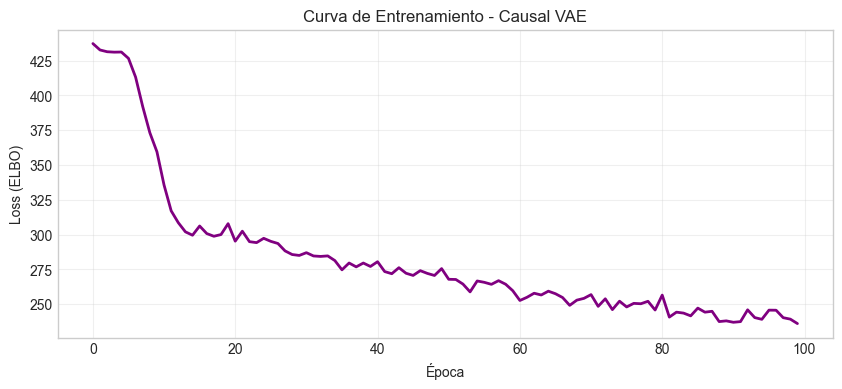

In [14]:
# Visualizar curva de pérdida del VAE
plt.figure(figsize=(10, 4))
plt.plot(vae_losses, color='purple', linewidth=2)
plt.xlabel('Época')
plt.ylabel('Loss (ELBO)')
plt.title('Curva de Entrenamiento - Causal VAE')
plt.grid(True, alpha=0.3)
plt.show()

In [15]:
# Generar contrafactuales
# Seleccionar una muestra
sample_idx = 0
original_sample = torch.FloatTensor(X_test[sample_idx:sample_idx+1]).to(device)

print("Muestra original:")
for i, (name, val) in enumerate(zip(feature_names, X_test[sample_idx])):
    print(f"  {name}: {val:.3f}")

print(f"\nClase real: {'Sostenible' if y_test[sample_idx] == 1 else 'Insostenible'}")

Muestra original:
  SST_C: -0.431
  Salinity_ppt: 0.537
  Chlorophyll_mg_m3: -0.537
  pH: 0.785
  Fleet_Size: 0.473
  Fishing_Effort_hours: 0.491
  Fuel_Consumption_L: 0.437
  Fish_Price_USD_ton: -0.905
  Fuel_Price_USD_L: -0.601
  Operating_Cost_USD: 0.236
  Capture_Production_Mt: 0.801
  Aquaculture_Production_Mt: 0.774
  Total_Production_Mt: 0.797
  CPUE: -0.112

Clase real: Sostenible


In [16]:
# Generar contrafactuales variando la dimensión latente 0
causal_vae.eval()

interventions = {
    'Bajo': {0: -2.0},
    'Medio': {0: 0.0},
    'Alto': {0: 2.0}
}

counterfactuals = {}
for name, intervention in interventions.items():
    cf = causal_vae.generate_counterfactual(original_sample, intervention)
    counterfactuals[name] = cf.cpu().numpy().squeeze()

# Visualizar diferencias
print("\nContrafactuales generados:")
print("=" * 60)

cf_df = pd.DataFrame(counterfactuals, index=feature_names)
cf_df['Original'] = X_test[sample_idx]
print(cf_df.round(3))


Contrafactuales generados:
                            Bajo  Medio   Alto  Original
SST_C                     -0.427 -0.382  0.128    -0.431
Salinity_ppt               0.374  0.037 -0.137     0.537
Chlorophyll_mg_m3          0.037 -0.338 -0.272    -0.537
pH                         0.089  0.257  0.605     0.785
Fleet_Size                -0.027 -0.022 -0.051     0.473
Fishing_Effort_hours       0.720 -0.366 -0.143     0.491
Fuel_Consumption_L         0.582 -0.373 -0.196     0.437
Fish_Price_USD_ton         0.010 -0.309 -0.408    -0.905
Fuel_Price_USD_L           0.319  0.143  0.348    -0.601
Operating_Cost_USD         0.531 -0.364 -0.158     0.236
Capture_Production_Mt      0.574  0.184 -0.075     0.801
Aquaculture_Production_Mt  0.677  0.162 -0.067     0.774
Total_Production_Mt        0.696  0.171 -0.047     0.797
CPUE                      -0.446  0.545 -0.050    -0.112


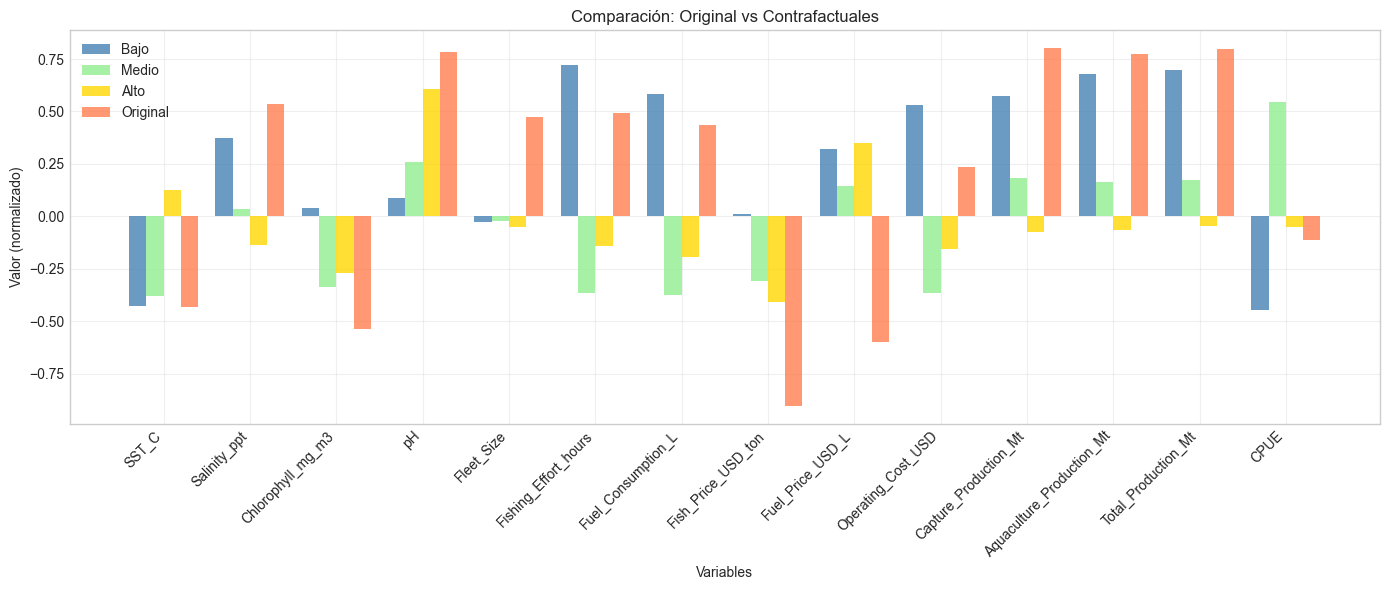

In [17]:
# Visualizar contrafactuales
fig, ax = plt.subplots(figsize=(14, 6))

x = np.arange(len(feature_names))
width = 0.2

colors = ['steelblue', 'lightgreen', 'gold', 'coral']
for i, (name, values) in enumerate(cf_df.items()):
    ax.bar(x + i * width, values, width, label=name, color=colors[i], alpha=0.8)

ax.set_xlabel('Variables')
ax.set_ylabel('Valor (normalizado)')
ax.set_title('Comparación: Original vs Contrafactuales')
ax.set_xticks(x + width * 1.5)
ax.set_xticklabels(feature_names, rotation=45, ha='right')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 6. Comparación de Modelos

In [18]:
# Comparar resultados
from sklearn.metrics import precision_score, recall_score, f1_score

results_comparison = {
    'MLP': mlp_results,
    'BNN': {
        'accuracy': bnn_accuracy,
        'precision': precision_score(y_test, bnn_preds, zero_division=0),
        'recall': recall_score(y_test, bnn_preds, zero_division=0),
        'f1': f1_score(y_test, bnn_preds, zero_division=0)
    }
}

print("=" * 60)
print("COMPARACIÓN DE MODELOS")
print("=" * 60)

comparison_df = pd.DataFrame({
    model: {k: v for k, v in metrics.items() if k != 'confusion_matrix'}
    for model, metrics in results_comparison.items()
}).T

print(comparison_df.round(4))

COMPARACIÓN DE MODELOS
     accuracy  precision  recall      f1  auc_roc
MLP    0.9133     0.9214  0.9847  0.9520   0.9303
BNN    0.9067     0.9270  0.9695  0.9478      NaN


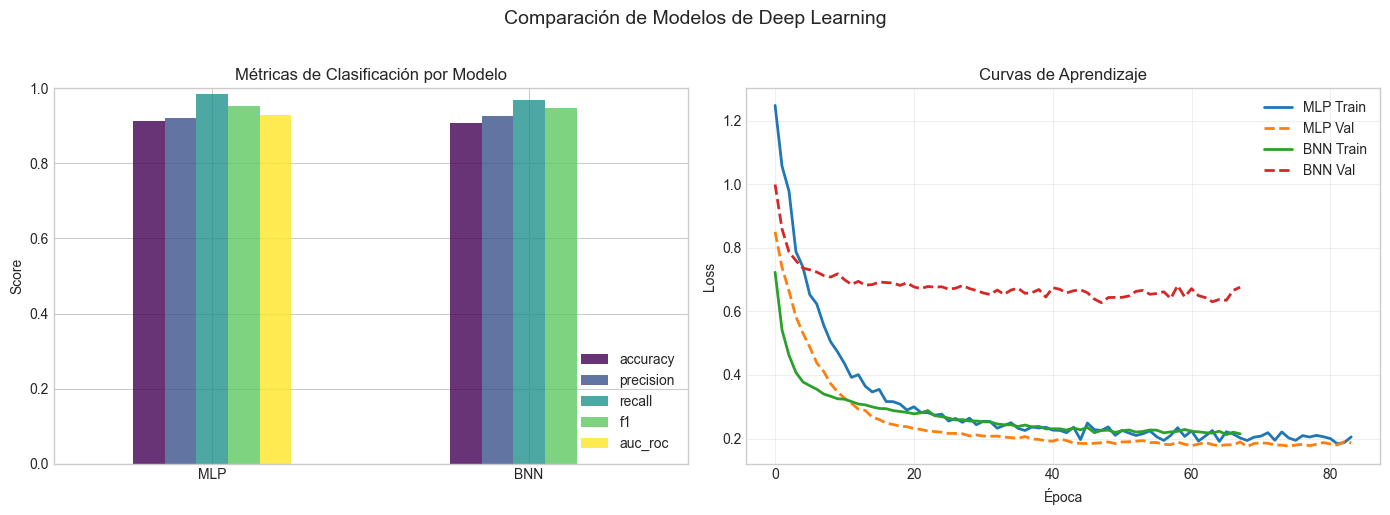

In [19]:
# Visualizar comparación
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 1. Métricas por modelo
comparison_df.plot(kind='bar', ax=axes[0], colormap='viridis', alpha=0.8)
axes[0].set_title('Métricas de Clasificación por Modelo')
axes[0].set_ylabel('Score')
axes[0].set_ylim(0, 1)
axes[0].legend(loc='lower right')
axes[0].tick_params(axis='x', rotation=0)

# 2. Curvas de pérdida
axes[1].plot(mlp_history.train_loss, label='MLP Train', linewidth=2)
axes[1].plot(mlp_history.val_loss, label='MLP Val', linewidth=2, linestyle='--')
axes[1].plot(bnn_history.train_loss, label='BNN Train', linewidth=2)
axes[1].plot(bnn_history.val_loss, label='BNN Val', linewidth=2, linestyle='--')
axes[1].set_xlabel('Época')
axes[1].set_ylabel('Loss')
axes[1].set_title('Curvas de Aprendizaje')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.suptitle('Comparación de Modelos de Deep Learning', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

## 7. Resumen y Conclusiones

In [20]:
print("=" * 70)
print("RESUMEN - FASE D: DEEP LEARNING PARA SOSTENIBILIDAD PESQUERA")
print("=" * 70)

print("""
MODELOS IMPLEMENTADOS:

1. MLP (Multilayer Perceptron)
   - Arquitectura: Input -> [64, 32, 16] -> Output
   - Características: Dropout, BatchNorm, ReLU
   - Uso: Baseline de clasificación

2. BNN (Bayesian Neural Network)
   - Arquitectura: Capas bayesianas con pesos estocásticos
   - Características: Cuantificación de incertidumbre epistémica
   - Uso: Predicción con intervalos de confianza

3. Causal VAE
   - Arquitectura: Encoder-Decoder con estructura causal
   - Características: Generación de contrafactuales
   - Uso: Análisis "¿qué pasaría si...?"

VENTAJAS:
- BNN proporciona incertidumbre en predicciones
- Predicciones incorrectas tienen mayor incertidumbre
- VAE permite explorar escenarios contrafactuales

ARCHIVOS GENERADOS:
- src/deep_learning/models.py
- src/deep_learning/training.py
- notebooks/04_Deep_Learning_Sustainability.ipynb
""")

print("\n" + "=" * 70)
print("FASE D COMPLETADA")
print("=" * 70)

RESUMEN - FASE D: DEEP LEARNING PARA SOSTENIBILIDAD PESQUERA

MODELOS IMPLEMENTADOS:

1. MLP (Multilayer Perceptron)
   - Arquitectura: Input -> [64, 32, 16] -> Output
   - Características: Dropout, BatchNorm, ReLU
   - Uso: Baseline de clasificación

2. BNN (Bayesian Neural Network)
   - Arquitectura: Capas bayesianas con pesos estocásticos
   - Características: Cuantificación de incertidumbre epistémica
   - Uso: Predicción con intervalos de confianza

3. Causal VAE
   - Arquitectura: Encoder-Decoder con estructura causal
   - Características: Generación de contrafactuales
   - Uso: Análisis "¿qué pasaría si...?"

VENTAJAS:
- BNN proporciona incertidumbre en predicciones
- Predicciones incorrectas tienen mayor incertidumbre
- VAE permite explorar escenarios contrafactuales

ARCHIVOS GENERADOS:
- src/deep_learning/models.py
- src/deep_learning/training.py
- notebooks/04_Deep_Learning_Sustainability.ipynb


FASE D COMPLETADA
